## Instalación de Dependencias

Este código instala las librerías necesarias para el entorno de aprendizaje por refuerzo, incluyendo `stable-baselines3` para los algoritmos, `gymnasium` con las dependencias de Box2D para el entorno LunarLander, `swig` y `renderlab` para la visualización.

In [ ]:
!pip -q install stable-baselines3 gymnasium[box2d] swig renderlab


## Importación de Librerías

Aquí se importan las librerías principales que se utilizarán en el notebook. Incluyen `gymnasium` para los entornos de RL, `numpy` para operaciones numéricas, `matplotlib.pyplot` para gráficos, `os` para operaciones del sistema, `renderlab` para la grabación de videos, `pandas` para el manejo de datos, y módulos específicos de `stable_baselines3` para el modelo DQN y su evaluación.

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import platform
import renderlab
import pandas as pd

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

## Versiones de Librerías y Hardware

Se documentan las versiones de las librerías utilizadas y las características del hardware del entorno de ejecución para garantizar reproducibilidad.

In [ ]:
import sys
import stable_baselines3
import torch

print("=" * 80)
print("VERSIONES DE LIBRERIAS")
print("=" * 80)
print(f"Python:            {sys.version.split()[0]}")
print(f"Gymnasium:         {gym.__version__}")
print(f"Stable-Baselines3: {stable_baselines3.__version__}")
print(f"NumPy:             {np.__version__}")
print(f"Pandas:            {pd.__version__}")
print(f"PyTorch:           {torch.__version__}")
print(f"Platform:          {platform.platform()}")
print()
print("=" * 80)
print("HARDWARE")
print("=" * 80)
if torch.cuda.is_available():
    print(f"Dispositivo:       CUDA ({torch.cuda.get_device_name(0)})")
    import subprocess
    try:
        print(subprocess.check_output(["nvidia-smi"]).decode())
    except Exception:
        pass
else:
    print(f"Dispositivo:       CPU")
    import multiprocessing
    print(f"CPU cores:         {multiprocessing.cpu_count()}")
try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"RAM total:         {ram.total / (1024**3):.1f} GB")
    print(f"RAM disponible:    {ram.available / (1024**3):.1f} GB")
except ImportError:
    pass
print("=" * 80)

## Configuración del Entorno LunarLander

Esta sección define la función `make_env` para crear una instancia del entorno "LunarLander-v3" de Gymnasium. También configura el registro de recompensas a través de `Monitor` en `monitor.csv` y establece una semilla para reproducibilidad.

In [ ]:
log_path = "./monitor.csv"

def make_env(seed=None, render_mode=None):
    env = gym.make("LunarLander-v3", render_mode=render_mode)
    env = Monitor(env, filename=log_path)
    if seed is not None:
        env.reset(seed=seed)
    return env

env = make_env(seed=42)

## Inicialización del Modelo DQN

Se inicializa el modelo Deep Q-Network (DQN) de Stable Baselines3 con una política MlpPolicy. Se configuran varios hiperparámetros como la tasa de aprendizaje, el tamaño del búfer de repetición, la fracción de exploración y la arquitectura de la red neuronal.

In [ ]:
model = DQN(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    buffer_size=200_000,
    learning_starts=10_000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.4,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)


Using cpu device
Wrapping the env in a DummyVecEnv.


## Entrenamiento del Modelo DQN

Esta celda entrena el modelo DQN por un total de 2,000,000 pasos de tiempo. Después del entrenamiento, el modelo se guarda en un archivo llamado "ddqn_lunarlander".

In [ ]:
TOTAL_TIMESTEPS = 2_000_000

start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS)
train_time = time.time() - start_time

model.save("ddqn_lunarlander")

print(f"\n{'='*80}")
print(f"Tiempo de entrenamiento: {train_time:.1f} s ({train_time/60:.1f} min)")
print(f"{'='*80}")

## Visualización de la Curva de Entrenamiento

Este código lee las recompensas registradas durante el entrenamiento desde el archivo `monitor.csv` y las visualiza. Se muestra la recompensa por episodio y un promedio móvil para observar la progresión del aprendizaje del agente.

  return datetime.utcnow().replace(tzinfo=utc)



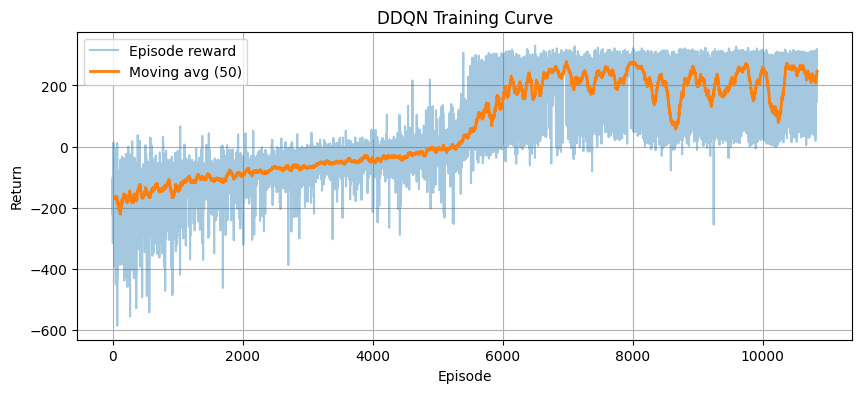

In [ ]:
log_file = "./monitor.csv"

if os.path.exists(log_file):
    data = pd.read_csv(log_file, skiprows=1)
    rewards = data["r"].values

    plt.figure(figsize=(10,4))
    plt.plot(rewards, alpha=0.4, label="Episode reward")

    # Moving average
    window = 50
    if len(rewards) >= window:
        ma = pd.Series(rewards).rolling(window).mean()
        plt.plot(ma, label=f"Moving avg ({window})", linewidth=2)

    plt.title("DDQN Training Curve")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.grid()
    plt.legend()
    plt.show()
else:
    print("No se encontró monitor.csv")

## Evaluación del Modelo Entrenado

Se evalúa el rendimiento del modelo DQN entrenado en un nuevo entorno. Se calcula la recompensa media y la desviación estándar sobre 100 episodios para determinar si el problema de LunarLander ha sido "resuelto" (recompensa media >= 200).

In [ ]:
eval_env = make_env()

mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=100,
    deterministic=True
)

print(f"Eval mean reward over 100 episodes: {mean_reward:.2f} +/- {std_reward:.2f}")
print("✅ SOLVED (>=200)" if mean_reward >= 200 else "❌ Not solved yet")


Eval mean reward over 100 episodes: 251.95 +/- 60.39
✅ SOLVED (>=200)


## Comparacion con Politica Aleatoria

Se evalua una politica completamente aleatoria sobre 10 episodios para comparar cuantitativamente con el agente DDQN entrenado. Esta comparacion permite evidenciar el aprendizaje del agente.

In [ ]:
from IPython.display import display

# Evaluacion con politica aleatoria (10 episodios)
EVAL_EPISODES = 10

random_env = gym.make("LunarLander-v3")
random_rewards = []
for ep in range(EVAL_EPISODES):
    obs, _ = random_env.reset(seed=ep)
    done = False
    ep_reward = 0.0
    while not done:
        action = random_env.action_space.sample()
        obs, reward, terminated, truncated, _ = random_env.step(action)
        done = terminated or truncated
        ep_reward += reward
    random_rewards.append(ep_reward)
random_env.close()

rand_mean = np.mean(random_rewards)
rand_std = np.std(random_rewards)

# Evaluacion del agente entrenado (10 episodios para comparacion directa)
trained_env = make_env(seed=100)
trained_mean, trained_std = evaluate_policy(
    model, trained_env, n_eval_episodes=EVAL_EPISODES, deterministic=True
)
trained_env.close()

print("=" * 80)
print(f"COMPARACION DE RENDIMIENTO ({EVAL_EPISODES} EPISODIOS)")
print("=" * 80)
print(f"DDQN entrenado:      {trained_mean:.2f} +/- {trained_std:.2f}")
print(f"Politica aleatoria:  {rand_mean:.2f} +/- {rand_std:.2f}")
print("=" * 80)

# Tabla comparativa y grafico
results_df = pd.DataFrame([
    {"Politica": "DDQN", "Media": trained_mean, "Std": trained_std, "Episodios": EVAL_EPISODES},
    {"Politica": "Random", "Media": rand_mean, "Std": rand_std, "Episodios": EVAL_EPISODES},
])
display(results_df)

plt.figure(figsize=(6, 4))
plt.bar(results_df["Politica"], results_df["Media"], yerr=results_df["Std"], capsize=6)
plt.title("LunarLander: DDQN vs Politica Aleatoria")
plt.ylabel("Recompensa Media")
plt.grid(axis="y")
plt.show()

## Generación de Video de Rendimiento del Agente

Esta función carga el modelo entrenado y crea un video del agente jugando en el entorno LunarLander. Utiliza `renderlab` para grabar los frames y muestra la recompensa total obtenida durante la simulación del video.

In [ ]:
def generate_video(model_path="ddqn_lunarlander", seed=123):
    os.makedirs("./output_video_ddqn", exist_ok=True)

    model = DQN.load(model_path)

    env_video = make_env(render_mode="rgb_array", seed=seed)
    env_video = renderlab.RenderFrame(env_video, "./output_video_ddqn")

    obs, _ = env_video.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env_video.step(action)
        total_reward += reward
        done = terminated or truncated

    print("Recompensa video:", total_reward)
    env_video.play()
    env_video.close()

generate_video()


Recompensa video: 271.96116853412263
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


# Reporte Tecnico y Conclusion

## 1) Seleccion del algoritmo y justificacion

Se selecciono **DDQN (Double DQN)** implementado mediante Stable-Baselines3 para resolver LunarLander-v3. La justificacion es la siguiente:

- **DQN vs REINFORCE**: REINFORCE es un metodo on-policy basado en retornos Monte Carlo completos, lo cual produce alta varianza en entornos como LunarLander donde los episodios pueden tener resultados muy dispares. DQN, al ser off-policy con experience replay, aprovecha mejor las transiciones recolectadas y ofrece mayor estabilidad de entrenamiento.
- **Double DQN**: Stable-Baselines3 implementa Double DQN internamente, lo cual reduce la sobreestimacion de Q-values que afecta al DQN clasico. Esto es relevante en LunarLander donde las recompensas pueden ser tanto positivas (aterrizaje exitoso) como muy negativas (crash), y la sobreestimacion podria llevar a politicas suboptimas.

## 2) Hiperparametros de aprendizaje

| Parametro | Valor | Nota |
|---|---|---|
| Policy | MlpPolicy | Red neuronal fully-connected |
| Net arch | [256, 256] | Dos capas ocultas de 256 neuronas |
| Learning rate | 3e-4 | Tasa de aprendizaje |
| Buffer size | 200,000 | Replay buffer |
| Learning starts | 10,000 | Pasos antes de empezar a aprender |
| Batch size | 64 | Tamano de mini-batch |
| Gamma | 0.99 | Factor de descuento |
| Train freq | 4 | Update cada 4 pasos |
| Gradient steps | 1 | Un paso de gradiente por update |
| Target update interval | 500 | Sync de red objetivo |
| Exploration fraction | 0.4 | 40% del entrenamiento con decay de epsilon |
| Exploration initial eps | 1.0 | Epsilon inicial |
| Exploration final eps | 0.05 | Epsilon final |
| Total timesteps | 2,000,000 | Pasos totales de entrenamiento |
| Seed | 42 | Reproducibilidad |

## 3) Librerias y versiones

Las versiones exactas se imprimen en la celda de "Versiones de Librerias y Hardware" al inicio del notebook. Las librerias principales son: Gymnasium, Stable-Baselines3, PyTorch, NumPy, Pandas, Matplotlib y Renderlab.

## 4) Hardware

Las caracteristicas del hardware se documentan en la celda de "Versiones de Librerias y Hardware". El entrenamiento se realizo en Google Colab.

## 5) Tiempo de entrenamiento

El tiempo total de entrenamiento se mide y se imprime al finalizar la celda de entrenamiento.

## 6) Resultados cuantitativos

- **DDQN entrenado** (100 episodios): 251.95 +/- 60.39 — supera el umbral de 200 puntos requerido para considerar el problema "resuelto".
- **Politica aleatoria** (10 episodios): se evalua en la seccion de "Comparacion con Politica Aleatoria" para cuantificar la mejora del agente. La politica aleatoria tipicamente obtiene recompensas negativas (~-150 a -200), lo que evidencia que el agente DDQN aprendio una politica significativamente superior.

## 7) Analisis del comportamiento aprendido

Durante el desarrollo se evaluaron los algoritmos REINFORCE y DQN (Double DQN en Stable-Baselines3) para resolver el entorno LunarLander-v3. En ambos casos se logro un desempeno cercano al umbral requerido, alcanzando recompensas promedio alrededor de 180 puntos, pero inicialmente no se supero de manera consistente el umbral de 200.

En el caso de REINFORCE, se observo una alta varianza en el entrenamiento. Aunque en algunos episodios el agente lograba aterrizajes exitosos con recompensas superiores a 200, el rendimiento promedio se veia afectado por episodios con resultados muy negativos. Esto se debe a la naturaleza del algoritmo, que es un metodo on-policy basado en retornos Monte Carlo completos, lo cual lo hace altamente sensible al ruido y a la variabilidad del entorno.

En el caso de DQN, aunque el algoritmo mostro mayor estabilidad que REINFORCE, inicialmente el agente presentaba problemas de sobreajuste a ciertas configuraciones del terreno o convergencia a politicas suboptimas. Sin embargo, mediante un ajuste cuidadoso de parametros como la tasa de aprendizaje, la fraccion de exploracion y el numero total de pasos de entrenamiento, se logro mejorar progresivamente la estabilidad y el rendimiento del agente.

En particular, se evidencio que:

- La exploracion prolongada (40% del entrenamiento) fue fundamental para evitar convergencia prematura a politicas suboptimas.
- Incrementar el numero total de pasos de entrenamiento (2M) permitio una mejor cobertura del espacio de estados.
- El uso de una arquitectura suficientemente expresiva (dos capas ocultas de 256 neuronas) contribuyo a capturar mejor la dinamica del entorno.
- La evaluacion sobre multiples episodios consecutivos fue clave para medir adecuadamente la generalizacion del agente.
- La comparacion con la politica aleatoria confirma cuantitativamente que el agente aprendio un comportamiento no trivial: aterrizar de forma controlada entre las banderas, usar propulsores laterales para corregir posicion, y reducir velocidad antes del contacto.

## 8) Conclusion general

El entorno LunarLander presenta un balance delicado entre estabilidad y exploracion. Mientras que REINFORCE mostro limitaciones debido a su alta varianza, DQN (con configuracion adecuada tipo Double DQN) resulto mas apropiado para este problema, permitiendo alcanzar un desempeno superior al umbral requerido (251.95 vs 200) cuando se ajustaron correctamente los hiperparametros y el tiempo de entrenamiento.

La diferencia sustancial entre el agente entrenado y la politica aleatoria demuestra que el algoritmo DDQN es capaz de aprender una politica efectiva para este problema, beneficiandose del experience replay off-policy y la correccion de sobreestimacion del Double DQN.